#### 분류평가
- 정확도만으로 불균형한 레이블 데이터 세트에서 평가지표로 사용하기에는 부적합
- 정확도가 가지는 분류 평가 지표로의 한계점을 극복하기 위해 여러가지 분류 지표와 함께 적용해야 함

#### confusion Matrix(혼돈행렬,오차행렬)
- 이진분류에서 성능 지표로 잘 활용되는 오차 행렬은 학습된 분류 모델이 예측을 수행하면 얼마나 혼동될 수 있는지도 함께 보여주는 지표
- 이진 분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 보여줌

#### 평가 지표
- TP, FP, FN, TN은 예측 클래스와 실제 클래스의 Positive 결정 값과 Negative 결정 값의 결합에 따라 결정
- 앞문자 True/False는 예측값과 실제 값이 같은가/틀린가를 의미하고 뒤 문자 N/P는 예측 결과값이 부정/긍정을 의미
- 정확도 = (TP + TN) / (TP + TN + FN + FP)
- 정밀도 = TP/(TP + FP) : P로 예측한 것 중에서 실제도 P
- 재현율 = TP/(TP + FN) : 실제 P인 것 중에서 예측도 P
- F1 score = 2 * (정밀도 * 재현율) / (정밀도 + 재현율) : 정밀도와 재현율이 어느 한 쪽으로 치우치지 않는 수치를 나타낼 때 높아짐
- 정밀도와 재현율은 Positive 데이터 세트의 예측 성능에 조금 더 초점을 맞춘 평가지표
- 재현율이 중요 지표인 경우 : 양성 데이터를 음성으로 잘못 판단하면 업무상 큰 영향이 발생하는 경우(암 진단, 보험사기)
- 정밀도가 중요 지표인 경우: 스팸 메일 여부 판단, 스팸 메일이 아닌데 스팸 메일로 분류하여 업무 차질 발생.

#### 정밀도 및 재현율 활용 시 유의사항
- 정밀도와 재현율 성능 수치는 어느 한쪽만 참조하면 극단적인 수치 조작이 가능
- 정밀도 100%가 되는 방법 : 확실한 기준이 되는 경우만 P로 예측하고 나머지는 모두 N으로 예측 TP/(TP+FP) = 1
- 재현률이 100%가 되는 방법 : 실제 양성 1000명 중 30명 TP/(TP+FN) = 30/(30+1) 
- 암 예측 모델에서 재현율을 높인다고 주로 판정한다면 환자의 불만, 불평이 커짐

In [1]:
from sklearn.metrics import accuracy_score, precision_score,recall_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')


def get_clf_eval(y_test,pred):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    print(f'오차 행렬:\n {confusion}')
    print(f'정확도: {round(accuracy,4)}, 정밀도: {round(precision,4)}, 재현율: {round(recall,4)}')

In [2]:
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler



def fillnas(df):
    def callname(x):
        m = re.compile('[A-Za-z]+[.]')
        p = re.findall(m,x)
        return p[0]
    
    df['Callname']=df.Name.apply(lambda x:callname(x))
    
    df1 = df.loc[df.Age.isnull()]
    age_nulllist = list(set(df1.Callname.values.tolist()))
    
    df2 = df.loc[df.Age.notnull()]
    pivot = pd.pivot_table(df2, index = 'Callname', values = 'Age',aggfunc = 'mean')
    
    for age in age_nulllist:
        df.loc[(df.Age.isnull())&(df.Callname == age),['Age']]=(pivot.loc[age][0])
        
    df['Embarked'].fillna(method = 'ffill',inplace=True)
    
    df3 = df.loc[df.Cabin.notnull()]

    df3['Cabins'] = df3['Cabin'].str[:1]
    df4 = df.loc[df.Cabin.isnull()]
    
    for i in range(1,4):
        df33 = df3.loc[df3.Pclass == i]
        cabin_fill_list=list(set(df33.Cabins.values.tolist()))
        df44 = df4.loc[df4.Pclass == i]
        fill_index = list(df44.index)
        for index in fill_index:
            df.loc[index,'Cabin'] = np.random.choice(cabin_fill_list)
            
    return df

# 불필요 항목 제거
def drop_feat(df):
    df.drop(['PassengerId','Name','Ticket','Callname'],axis=1,inplace = True)
    return df

def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    scaler = MinMaxScaler()
    scaler.fit(df[['Fare']])
    fare_scaled = scaler.transform(df[['Fare']])
    df['Fare'] = fare_scaled
    
    return df

def transform_features(df):
    df = fillnas(df)
    df = drop_feat(df)
    df = format_features(df)
    return df
        

In [3]:
import pandas as pd
import numpy as np
t_df = pd.read_csv('./dataset/train.csv')

y_t_df = t_df['Survived']
X_t_df = t_df.drop('Survived',axis = 1)
X_t_df = transform_features(X_t_df)

In [4]:
X_t_df

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.000000,1,0,0.014151,6,2
1,1,0,38.000000,1,0,0.139136,2,0
2,3,0,26.000000,0,0,0.015469,6,2
3,1,0,35.000000,1,0,0.103644,2,2
4,3,1,35.000000,0,0,0.015713,5,2
...,...,...,...,...,...,...,...,...
886,2,1,27.000000,0,0,0.025374,4,2
887,1,0,19.000000,0,0,0.058556,1,2
888,3,0,21.773973,1,2,0.045771,4,2
889,1,1,26.000000,0,0,0.058556,2,0


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
X_train,X_test, y_train, y_test = train_test_split(X_t_df,y_t_df,test_size = 0.2,random_state = 11)

lr_clf = LogisticRegression(random_state = 11)
lr_clf.fit(X_train,y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test,pred)

오차 행렬:
 [[107  11]
 [ 15  46]]
정확도: 0.8547, 정밀도: 0.807, 재현율: 0.7541


In [6]:
# 오차행렬을 보고 수작업으로 계산
confusion = confusion_matrix(y_test,pred)
accuracy=(confusion[0][0]+confusion[1][1])/(confusion.sum())
precision=(confusion[1][1])/(confusion[1][1]+confusion[0][1])
recall=(confusion[1][1]/(confusion[1][0]+confusion[1][1]))
print('accuracy: ',round(accuracy,4))
print('precision: ',round(precision,4))
print('recall:',round(recall,4))
print('f1 score', round(2*(precision*recall)/(precision+recall),4))

accuracy:  0.8547
precision:  0.807
recall: 0.7541
f1 score 0.7797


In [7]:
# precision/ recall trade-off
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
pred_proba_result = np.concatenate([pred_proba,pred.reshape(-1,1)],axis=1)
pred_proba_result[:3]

array([[0.55768996, 0.44231004, 0.        ],
       [0.88776689, 0.11223311, 0.        ],
       [0.88519386, 0.11480614, 0.        ]])

In [8]:
from sklearn.preprocessing import Binarizer

X = [[1,-1,2],
    [2,0,0],
    [0,1.1,1.2]]

binarizer = Binarizer(threshold = 1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [9]:
custom_threshold = 0.5
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict=binarizer.transform(pred_proba_1)


custom_predict

get_clf_eval(y_test,custom_predict)

오차 행렬:
 [[107  11]
 [ 15  46]]
정확도: 0.8547, 정밀도: 0.807, 재현율: 0.7541


In [10]:
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict=binarizer.transform(pred_proba_1)


custom_predict

get_clf_eval(y_test,custom_predict)

오차 행렬:
 [[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197


In [11]:
# 임계값을 0.4, 0.45,0.5,0.55,0.6으로 변경시 각 평가지표의 변화를 출력
custom_thresholds = [0.4, 0.45,0.5,0.55,0.6]
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
for ct in custom_thresholds:
    print('Threshold: ',ct)
    binarizer = Binarizer(threshold = ct).fit(pred_proba_1)
    custom_predict=binarizer.transform(pred_proba_1)
    get_clf_eval(y_test,custom_predict)

Threshold:  0.4
오차 행렬:
 [[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197
Threshold:  0.45
오차 행렬:
 [[100  18]
 [ 13  48]]
정확도: 0.8268, 정밀도: 0.7273, 재현율: 0.7869
Threshold:  0.5
오차 행렬:
 [[107  11]
 [ 15  46]]
정확도: 0.8547, 정밀도: 0.807, 재현율: 0.7541
Threshold:  0.55
오차 행렬:
 [[110   8]
 [ 15  46]]
정확도: 0.8715, 정밀도: 0.8519, 재현율: 0.7541
Threshold:  0.6
오차 행렬:
 [[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.898, 재현율: 0.7213


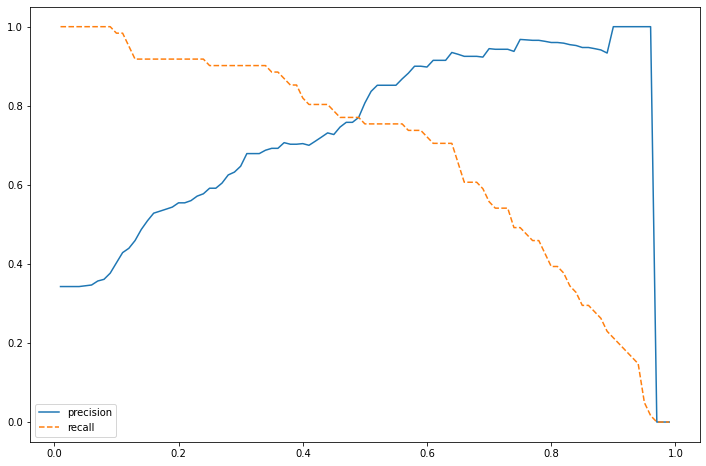

In [12]:
# 임계값을 0~1로 변경시킬 때 precision과 recall의 변화 추세를 시각화하여 출력
import matplotlib.pyplot as plt

xs = np.arange(1,100)*0.01
prec_list = []
reca_list = []
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
for i in range(99):
    cust_threshold = xs[i]
    binarizer = Binarizer(threshold = cust_threshold).fit(pred_proba_1)
    custom_predict=binarizer.transform(pred_proba_1)
    precision = precision_score(y_test,custom_predict)
    prec_list.append(precision)
    recall = recall_score(y_test,custom_predict)
    reca_list.append(recall)
    
plt.figure(figsize = (12,8))
plt.plot(xs, prec_list,label = 'precision')
plt.plot(xs,reca_list,ls = '--',label = 'recall')
plt.legend()
plt.show()

#### ROC curve & AUC
- 수신자 판단 곡선이라고 하며 머신러닝의 이진 분류 모델의 예측 성능을 판단하는 중요한 평가 지표
- FPR이 변할 때 TPR이 어떻게 변하는지를 나타내는 곡선으로 FPR = 1 - TNR(특이성), TPR은 재현율(민감도)를 나타낸다.
- TNR = TN/(TN+FP)이며 FPR = FP/(TN+FP)
- ROC 곡선은 FPR을 0부터 1까지 변경하면서 FPR을 구하고 이 FPR 값의 변화에 따른 TPR 변화 값을 구함
- FPR을 0에서 1까지 변경하는 것은 P 예측값을 결정하는 기준인 분류 결정 임계값을 변경
- FPR을 0으로 만드려면 임계값을 1로 지정하고 반대로 FPR을 1로 만드려면 임계값을 0으로 지정한다


In [13]:
from sklearn.metrics import roc_curve
pred_proba_class1= lr_clf.predict_proba(X_test)[:,1]

def roc_curve_plot(y_test,pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test,pred_proba_c1)
    thresholds[0]

    plt.plot(fprs, tprs,label = 'ROC')
    plt.plot([0,1],[0,1],'k--',label = 'Random')
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1-Specifity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
    plt.show()

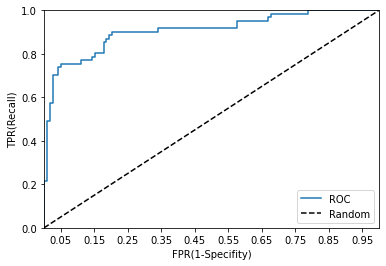

In [14]:
roc_curve_plot(y_test,pred_proba_class1)

In [15]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test,pred_proba)
round(roc_score,4)

0.9062

In [16]:
def get_clf_evals(y_test,pred=None,pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test,pred_proba)
    
    print(f'오차 행렬:\n {confusion}')
    print(f'정확도: {round(accuracy,4)}, 정밀도: {round(precision,4)}, 재현율: {round(recall,4)}, f1 score: {round(f1,4)}, auc: {round(roc_auc,4)}')

In [17]:
get_clf_evals(y_test,pred,pred_proba)

오차 행렬:
 [[107  11]
 [ 15  46]]
정확도: 0.8547, 정밀도: 0.807, 재현율: 0.7541, f1 score: 0.7797, auc: 0.9062


[과제] train.csv 파일을 불러와서 분류모델링 평가를 아래와 같이 수행하세요.
- dt 모델을 적용하고 GridSearchCV를 사용, 교차검증과 성능 개선을 위한 하이퍼파라미터 튜닝
- accuracy에 추가하여 confusion matrix, accuracy, precision, recall, roc auc score 평가


In [18]:
tdf = pd.read_csv('./dataset/train.csv')
y_tdf = tdf['Survived']
X_tdf = tdf.drop('Survived',axis = 1)
X_tdf = transform_features(X_tdf)
X_tdf.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.0,1,0,0.014151,4,2
1,1,0,38.0,1,0,0.139136,2,0
2,3,0,26.0,0,0,0.015469,6,2
3,1,0,35.0,1,0,0.103644,2,2
4,3,1,35.0,0,0,0.015713,5,2


In [19]:
# dt 모델을 적용하고 GridSearchCV를 사용, 교차검증과 성능 개선을 위한 하이퍼파라미터 튜닝
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_train,X_test, y_train, y_test = train_test_split(X_tdf,y_tdf,test_size = 0.2,random_state = 11)

dt_clf = DecisionTreeClassifier(random_state = 11)
dt_clf.fit(X_train,y_train)
dt_pred = dt_clf.predict(X_test)
print('dt_clf',accuracy_score(y_test,dt_pred))

dt_clf 0.8268156424581006


In [20]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf,X_tdf,y_tdf,cv = 5)
for iter_count ,accuracy in enumerate(scores):
    print(iter_count, accuracy)
    
print(np.mean(scores))

0 0.7206703910614525
1 0.7415730337078652
2 0.797752808988764
3 0.7359550561797753
4 0.7696629213483146
0.7531228422572342


In [21]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2,3,5,10],'min_samples_split':[2,3,5],'min_samples_leaf':[1,5,8]}

grid_dclf = GridSearchCV(dt_clf,param_grid=parameters,scoring='accuracy',cv=5)
grid_dclf.fit(X_train,y_train)

print(grid_dclf.best_params_)
print(grid_dclf.best_score_)
best_dclf = grid_dclf.best_estimator_

dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test,dpredictions)

print(accuracy)

{'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
0.807633211858564
0.88268156424581


In [22]:
# accuracy에 추가하여 confusion matrix, accuracy, precision, recall, roc auc score 평가
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
pred_proba = dt_clf.predict_proba(X_test)[:,1]

def get_clf_evals(y_test,pred=None,pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test,pred_proba)
    
    print(f'오차 행렬:\n {confusion}')
    print(f'정확도: {round(accuracy,4)}, 정밀도: {round(precision,4)}, 재현율: {round(recall,4)}, f1 score: {round(f1,4)}, auc: {round(roc_auc,4)}')
    
get_clf_evals(y_test,dt_pred,pred_proba)

오차 행렬:
 [[102  16]
 [ 15  46]]
정확도: 0.8268, 정밀도: 0.7419, 재현율: 0.7541, f1 score: 0.748, auc: 0.8072


[과제] diabetes.csv 데이터세트를 이용해 다음사항을 수행하여 당뇨병 여부를 판단하는 머신러닝 예측 모델을 작성하고 평가하세요.

- SkinThickness 와 Insulin의 0 값은 상당히 많기 때문에 일괄 삭제가 어려우며 평균값으로 대체
- 정확도, 정밀도, 재현율, F1 Score, ROC_AUC Score를 포함하는 평가지표 사용자 함수 작성
- 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태로 시각화
- 전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상시키는 임계값 산출
- 산출된 임계값을 적용한 평가
  
  ※ 피처 정보
  
  'Pregnancies'(임신 횟수), 'Glucose'(포도당 부하 검사 수치), 'BloodPressure'(혈압), 'SkinThickness'(팔 삼두근 뒤쪽의 피하지방 측정값, 'Insulin'(혈청 인슈린), 'BMI'(체질량 지수), 'DiabetesPedigreeFunction'(당뇨 내력 가중치 값), 'Age', 'Outcome'


데이터 세트는 북아메리카 피마 지역 원주민의 Type-2 당뇨병 결과 데이터임.
고립된 지역에서 인디언 고유의 혈통이 지속돼 왔지만 20세기 후반에 들어서면서 서구화된 식습관으로 많은 당뇨 환자 발생


In [23]:
df = pd.read_csv('./dataset/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [24]:
# 함수 전처리
df.SkinThickness=df.SkinThickness.replace(0,round(df.SkinThickness.mean(),2))
df.Insulin=df.Insulin.replace(0,round(df.Insulin.mean(),2))
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35.00,79.8,33.6,0.627,50,1
1,1,85,66,29.00,79.8,26.6,0.351,31,0
2,8,183,64,20.54,79.8,23.3,0.672,32,1
3,1,89,66,23.00,94.0,28.1,0.167,21,0
4,0,137,40,35.00,168.0,43.1,2.288,33,1


In [25]:
# 평가지표 함수 작성
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

y_df = df['Outcome']
X_df = df.drop('Outcome',axis = 1)

X_train,X_test, y_train, y_test = train_test_split(X_df,y_df,test_size = 0.2,random_state = 11)

lr_clf = LogisticRegression(random_state = 11)
lr_clf.fit(X_train,y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]
def get_clf_evals(y_test,pred=None,pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test,pred_proba)
    
    print(f'오차 행렬:\n {confusion}')
    print(f'정확도: {round(accuracy,4)}, 정밀도: {round(precision,4)}, 재현율: {round(recall,4)}, f1 score: {round(f1,4)}, auc: {round(roc_auc,4)}')

get_clf_evals(y_test,pred,pred_proba)    

오차 행렬:
 [[90 10]
 [25 29]]
정확도: 0.7727, 정밀도: 0.7436, 재현율: 0.537, f1 score: 0.6237, auc: 0.8194


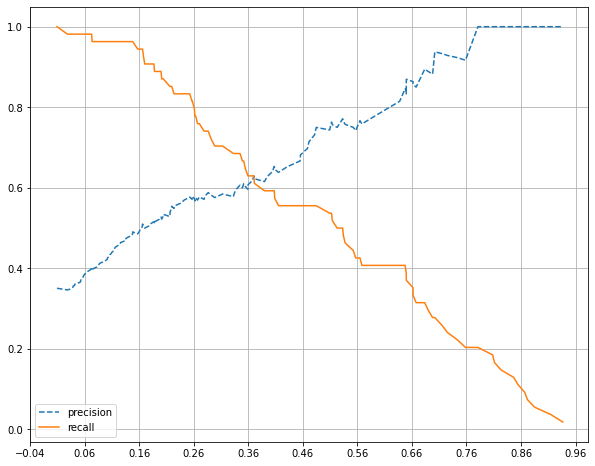

In [26]:
# 정밀도와 재현율의 임계값에 따른 값 변화를 시각화
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test,pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba_c1)
    
    plt.figure(figsize = (10,8))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds,precisions[0:threshold_boundary],linestyle='--',label = 'precision')
    plt.plot(thresholds,recalls[0:threshold_boundary],label = 'recall')
    
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.legend()
    plt.grid()
    plt.show()
precision_recall_curve_plot(y_test,pred_proba)

In [27]:
# 전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상시키는 임계값 산출
custom_thresholds = [0.32,0.35,0.38, 0.41,0.44,0.47,0.5]
pred_proba_1 = pred_proba.reshape(-1,1)
for ct in custom_thresholds:
    print('Threshold: ',ct)
    binarizer = Binarizer(threshold = ct).fit(pred_proba_1)
    custom_predict=binarizer.transform(pred_proba_1)
    get_clf_evals(y_test,custom_predict,pred_proba)

Threshold:  0.32
오차 행렬:
 [[73 27]
 [17 37]]
정확도: 0.7143, 정밀도: 0.5781, 재현율: 0.6852, f1 score: 0.6271, auc: 0.8194
Threshold:  0.35
오차 행렬:
 [[77 23]
 [18 36]]
정확도: 0.7338, 정밀도: 0.6102, 재현율: 0.6667, f1 score: 0.6372, auc: 0.8194
Threshold:  0.38
오차 행렬:
 [[80 20]
 [22 32]]
정확도: 0.7273, 정밀도: 0.6154, 재현율: 0.5926, f1 score: 0.6038, auc: 0.8194
Threshold:  0.41
오차 행렬:
 [[83 17]
 [24 30]]
정확도: 0.7338, 정밀도: 0.6383, 재현율: 0.5556, f1 score: 0.5941, auc: 0.8194
Threshold:  0.44
오차 행렬:
 [[85 15]
 [24 30]]
정확도: 0.7468, 정밀도: 0.6667, 재현율: 0.5556, f1 score: 0.6061, auc: 0.8194
Threshold:  0.47
오차 행렬:
 [[88 12]
 [24 30]]
정확도: 0.7662, 정밀도: 0.7143, 재현율: 0.5556, f1 score: 0.625, auc: 0.8194
Threshold:  0.5
오차 행렬:
 [[90 10]
 [25 29]]
정확도: 0.7727, 정밀도: 0.7436, 재현율: 0.537, f1 score: 0.6237, auc: 0.8194


In [28]:
# 산출된 임계값을 적용한 평가
binarizer = Binarizer(threshold=0.47)
pred_th_047 = binarizer.fit_transform(pred_proba.reshape(-1,1))

get_clf_evals(y_test,pred_th_047,pred_proba)

오차 행렬:
 [[88 12]
 [24 30]]
정확도: 0.7662, 정밀도: 0.7143, 재현율: 0.5556, f1 score: 0.625, auc: 0.8194


[도전과제]

아래는 백화점 고객의 1년 간 구매 데이터이다.

- (가) 제공 데이터 목록
- ① y_train.csv : 고객의 성별 데이터 (학습용), CSV 형식의 파일
- ② X_train.csv, X_test.csv : 고객의 상품구매 속성 (학습용 및 평가용), CSV 형식의 파일
- (나) 데이터 형식 및 내용
- ① y_train.csv (3,500명 데이터)
- ② X_train.csv (3,500명 데이터), X_test.csv (2,482명 데이터)

- 고객 3,500명에 대한 학습용 데이터(y_train.csv, X_train.csv)를 이용하여 성별예측 모형을 만든 후, 이를 평가용 데이터(X_test.csv)에 적용하여 얻은 2,482명 고객의 성별 예측값(남자일 확률)을 다음과 같은 형식의 CSV 파일로 생성하시오.(제출한 모델의 성능은 ROC-AUC 평가지표에 따라 채점)

- custid,gender
- 3500,0.267
- 3501,0.578
- 3502,0.885
․ ․ ․


- 성능이 우수한 예측모형을 구축하기 위해서는 적절한 데이터 전처리, Feature Engineering, 분류 알고리즘 사용, 초매개변수 최적화, 모형 앙상블 등이 수반되어야 한다